# Predicting Time Series using Amazon SageMaker

Timeseries forecasting is a very common problem and has be approached using quite a few methods. You can find a brief of the different approaches [here](https://en.wikipedia.org/wiki/Forecasting#Time_series_methods). We will be using DeepAR to solve the forecasting problem. DeepAR is an algorithm that uses Recurrent Neural Networks to forecast univariate time series. There are various aspects of DeepAR that are unique and you can find out more about how DeepAR differs from other algorithms [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

### Forecasting expected levels of pollution based on historical timeseries data

Pollution has been a challenge for many cities, especially large ones, around the world. Madrid, Spain is no different. In this Notebook, we will be analyzing and forecasting polluting and greenhouse gases. While one can independently try to predict levels of various greenhouse gases as well as other pollutants. They can often be correlated to each other, such as how the presence of pollutants such as NOx(Nitrous Oxides) and O3(Ozone). Other aspects that can impact pollution levels are seasons (winter, summer/spring) as well as altitudes at which the observations have been made. The presence of PM2.5(Particulate Matter less than 2 microns) has often found to have been impacted by weather.

## Setup

_This notebook was created and tested on an ml.m4.xlarge_
- You will require an Amazon S3 bucket to store the data in. This has to be in the same region as your Amazon SageMaker instance. [Here](https://docs.aws.amazon.com/AmazonS3/latest/user-guide/create-bucket.html) are the details on how you can create an Amazon S3 bucket.
- An IAM role ARN to provide training and hosting access to your data. You can find further details in the documentation on how to create these roles [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html).

## Data

Before we can use the data, you will need to log into Kaggle and copy the data to your Amazon S3 bucket i.e. the one you previously created. You will require a user account on Kaggle to do this. You can find an overview of the dataset [here](https://www.kaggle.com/decide-soluciones/air-quality-madrid/home). You can download the data from the __Data__ tab.

You may need to update your conda environment to get the latest on some of the packages we intend to install.

In [1]:
!sudo pip install missingno
!sudo pip install pyephem

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from zipfile import ZipFile
from io import BytesIO
from sagemaker import get_execution_role,Session,estimator

# Get our role setup
role = get_execution_role()
bucket = 'rnszsdemo' ## Replace with your bucket name
prefix = 'sagemaker/data/Madrid_Air_Quality' ## Replace with the folder structure inside your bucket or simply ''

Import what we will need later. To do that we should have that installed.

In [19]:
!sudo pip install missingno
!sudo pip install pyephem

    100% |████████████████████████████████| 204kB 4.4MB/s eta 0:00:01
  Running setup.py bdist_wheel for missingno ... done
  Stored in directory: /root/.cache/pip/wheels/39/fd/37/c8746c0f6f478363050f64f5fd179b4c4e16170410b34aa9f2
  Running setup.py bdist_wheel for seaborn ... done
  Stored in directory: /root/.cache/pip/wheels/fc/1c/74/c8f80a532c06a789599b8659b117ec7d7574cac4a06f7dabfe
Successfully built missingno seaborn
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
/usr/bin/yes: standard output: Broken pipe
/usr/bin/yes: write error
    100% |████████████████████████████████| 747kB 1.5MB/s eta 0:00:01
  Running setup.py bdist_wheel for pyephem ... done
  Stored in directory: /root/.cache/pip/wheels/d0/83/f1/f06b66dc94565b5c3e8ae149bc4722c3e98ec888fdc33ba506
Successfully built pyephem
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the

In [3]:
import boto3
import ephem
import datetime
import bisect
import json
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import time
import sagemaker.amazon.common as smac

The stations.csv file has the list of unique stations and their characteristics. Lets look at the stations file using Amazon S3 Select and see how many unique stations we are dealing with in this dataset. For an introduction to the S3 select feature refer [this](https://aws.amazon.com/blogs/aws/s3-glacier-select/) blog post. First lets see how many unique stations we have from which we got our readings. Our code borrows from aforementioned blogpost.

In [104]:
s3cl = boto3.client("s3")
resp = s3cl.select_object_content(
    Bucket=bucket,
    Key=prefix+'/'+'stations.csv',
    ExpressionType='SQL',
    Expression="select count(*) from s3object s",
    InputSerialization={'CSV': {"FileHeaderInfo": "Use"}},
    OutputSerialization={'CSV': {}}
)

for event in resp['Payload']:
    if 'Records' in event:
        rec=event['Records']['Payload'].decode('utf-8')
        print("The number of unique stations is : {}".format(rec))

The number of unique stations is : 24



In [105]:
stndata = pd.read_csv('s3://{}/{}/stations.csv'.format(bucket,prefix),index_col=0)

In [106]:
stndata.head()

,name,address,lon,lat,elevation
id,,,,,
28079004,Pza. de España,Plaza de España,-3.712247,40.423853,635
28079008,Escuelas Aguirre,Entre C/ Alcalá y C/ O’ Donell,-3.682319,40.421564,670
28079011,Avda. Ramón y Cajal,Avda. Ramón y Cajal esq. C/ Príncipe de Vergara,-3.677356,40.451475,708
28079016,Arturo Soria,C/ Arturo Soria esq. C/ Vizconde de los Asilos,-3.639233,40.440047,693
28079017,Villaverde,C/. Juan Peñalver,-3.713322,40.347139,604


The data in stations.csv looks small. What seems interesting is the difference in elevations for the stations, that is a factor that can affect air quality, But is the difference significant?

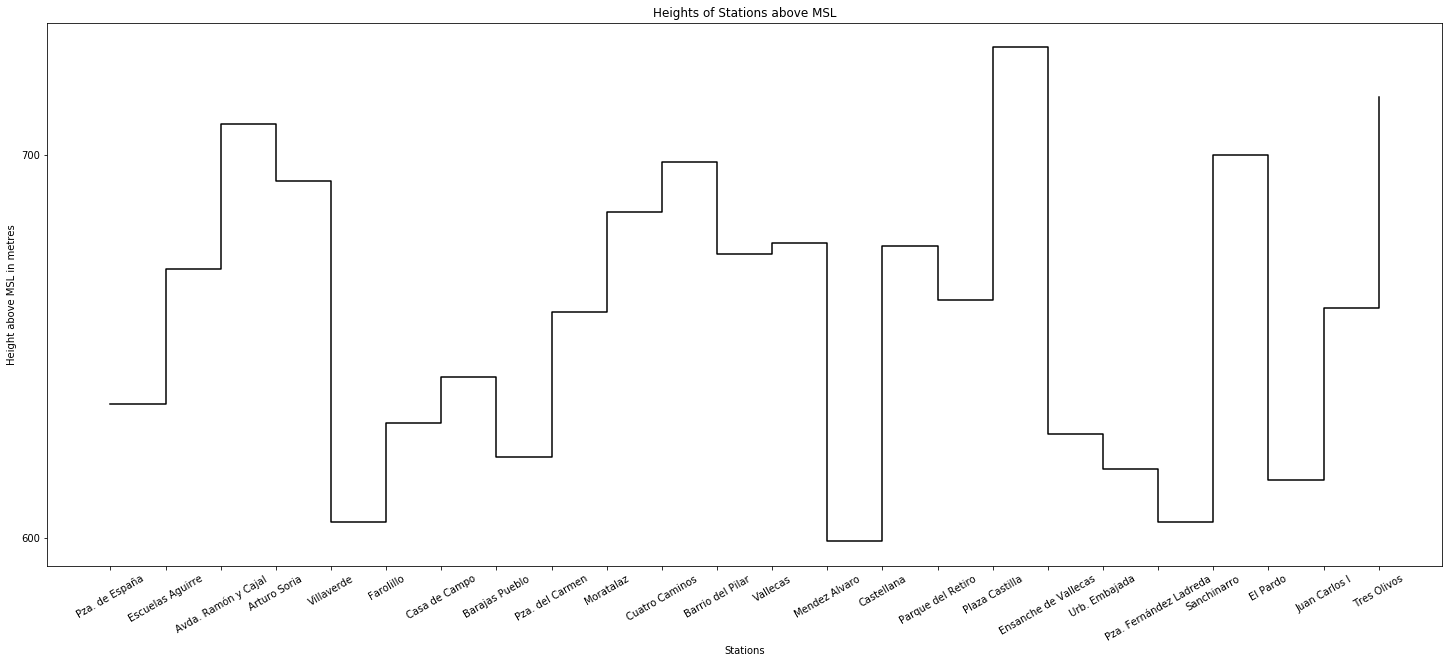

In [107]:
plt.figure(figsize=(25,10))
plt.xticks(np.arange(24),stndata['name'].tolist(),rotation=30)
plt.yticks(np.arange(100,800,step=100))
plt.xlabel("Stations")
plt.ylabel("Height above MSL in metres")
plt.title("Heights of Stations above MSL")
plt.plot(stndata['elevation'].tolist(),'k-',drawstyle='steps-post',label="Elevations above MSL")
plt.show()

Seems like the location of the station will impact the observations of the gases. Let us explore the data from the files for each year.

In [108]:
yearlydata = []
response = s3cl.list_objects_v2(
    Bucket=bucket,
    Prefix=prefix
)

for obj in response['Contents']:
    if obj['Key'].endswith('.zip'):
        fofinterest=obj['Key']
        
dlfl=s3cl.get_object(Bucket=bucket,Key=fofinterest)

with ZipFile(BytesIO(dlfl['Body'].read())) as zfl:
    for fl in zfl.namelist():
        if fl.endswith('.csv'):
            with zfl.open(fl) as csvfl:
                data = pd.read_csv(csvfl,parse_dates=True,index_col=None)
                yearlydata.append(data)

ydata = pd.concat(yearlydata)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Lets also take a look at how many observations we have from each station. 

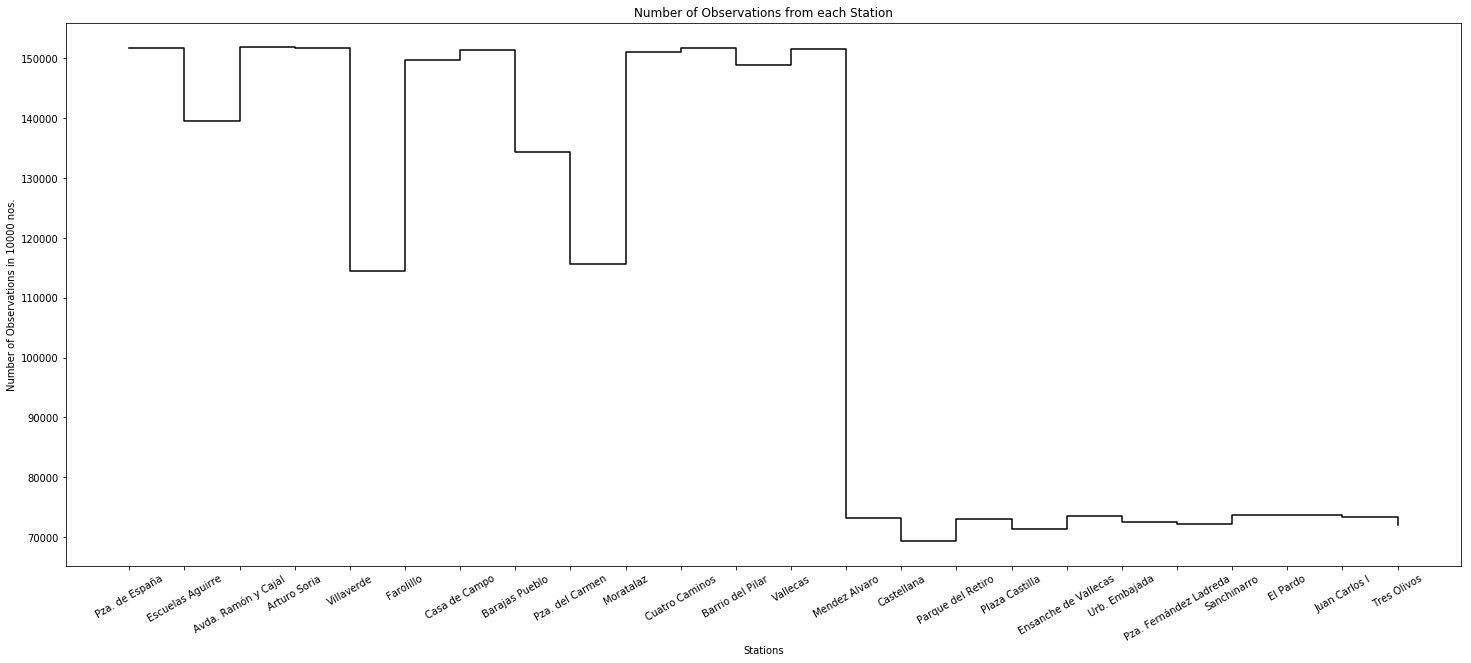

In [90]:
numrecords = []

for stnnum in stndata.index.values:
    numrecords.append(len(ydata[ydata['station'] == stnnum]))

plt.figure(figsize=(25,10))
plt.xticks(np.arange(24),stndata['name'].tolist(),rotation=30)
plt.yticks(np.arange(10000,200000,step=10000))
plt.xlabel("Stations")
plt.ylabel("Number of Observations in 10000 nos.")
plt.title("Number of Observations from each Station")
plt.plot(numrecords,'k-',drawstyle='steps-post',label="Distribution of Observations")
plt.show()

Seems like we may be missing some data in some parts of the dataset, which means it makes more sense to choose data that will give us meaningful data that we can train on and test with. Lets check the data we are missing.

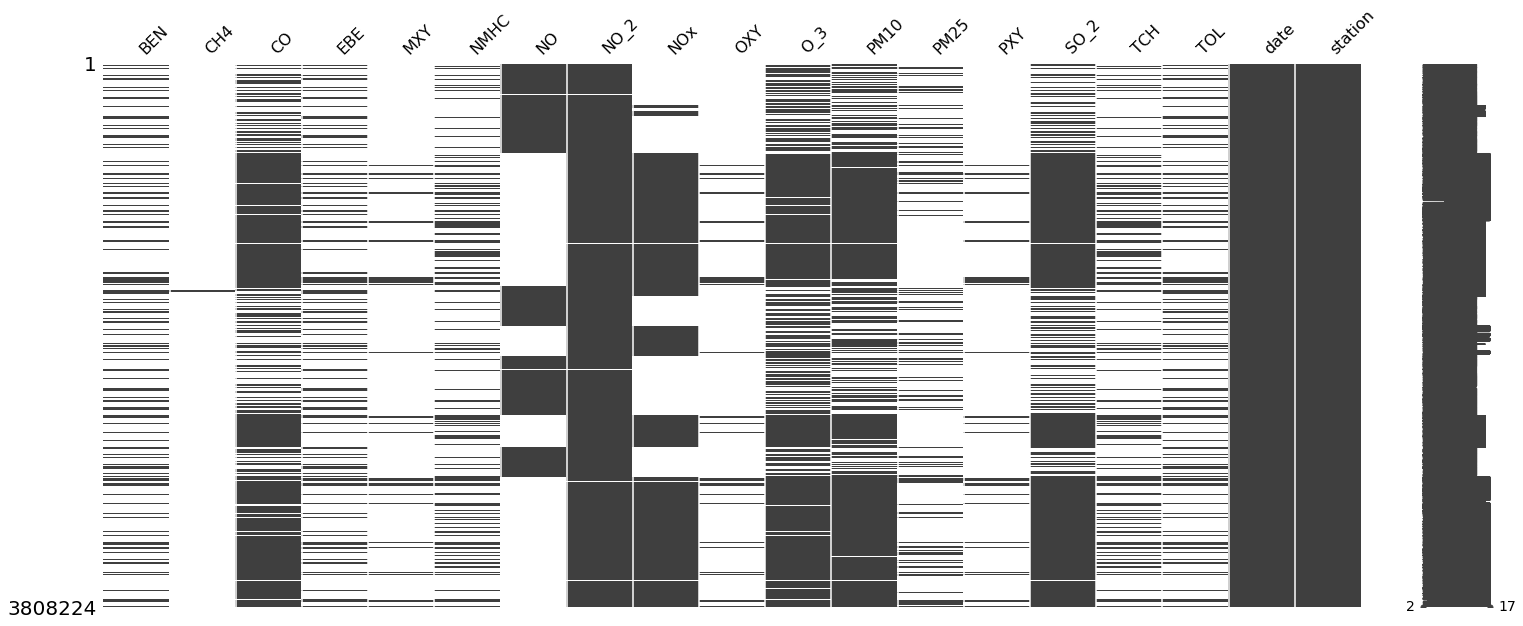

In [91]:
msno.matrix(ydata)

We are looking for longer term forecasts but the data has been recorded on an hourly basis. As a best practice, one should avoid using very large values for prediction length. To get longer term data we could resample the data in the dataframe we created above to a maintain a record for the data on a daily instead of an hourly basis. You can take a look at the best practices [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

In [92]:
## Lets get the unqiue values for the monitoring stations
stns=ydata['station'].unique()
newstns=stndata.index.values.tolist()
invalidstns=set(stns) - set(newstns)

## Since the number of stations in the data is more than the number of stations in the stations.csv 
## file we examined above, this is because of this statment in the dataset : "Please take into account 
## that most IDs that appear in the historical data do not map to an entry here: the original Open Data 
## file only provides information about the current stations, so those that ceased activity before 
## current revision (June 2018) have no associated information.". So now, we remove records from the 
## data that do not provide us with coherent data points.
for invstn in invalidstns:
    ydata = ydata[ydata.station != invstn]
    print("Station {} now removed.".format(invstn))

Station 28079009 now removed.
Station 28079012 now removed.
Station 28079014 now removed.
Station 28079015 now removed.
Station 28079099 now removed.
Station 28079019 now removed.
Station 28079021 now removed.
Station 28079022 now removed.
Station 28079023 now removed.
Station 28079025 now removed.
Station 28079026 now removed.
Station 28079001 now removed.
Station 28079003 now removed.
Station 28079006 now removed.
Station 28079007 now removed.


It would also be a good idea to only do the first 14 stations, just so we limit our processing in the interest of time.

In [93]:
numStnsToAnalyze=14 ## Reduce this if you don't have enough time.

## Separate data for newstns
dflist=[]

for stn in range(numStnsToAnalyze):
    truth=ydata['station']==newstns[stn]
    dflist.append(ydata[truth])

stndatamap = dict(zip(newstns,dflist)) ## A mapping for values and the corresponding stations
    
## Lets also create a dict for the stations, that we will use as categories, same for the gases
stncats = {k:v for (k,v) in zip(newstns,range(len(newstns)))}
gaslist = list(ydata.columns.values)[:len(list(ydata.columns.values))-2] ## 2 refers to the date and station columns
gascats = {k:v for (k,v) in zip(gaslist,range(len(gaslist)))}

Since we are looking for some longer term estimates, it makes sense to resample our hourly data to daily.

In [94]:
## But we first have to set index for all the dataframes we will be working with.
for stn in range(numStnsToAnalyze):
    stndatamap[newstns[stn]]['date']=pd.to_datetime(stndatamap[newstns[stn]]['date'], format='%Y-%m-%d %H:%M:%S')
    stndatamap[newstns[stn]]['station'].astype('int64')
    
for stn in range(numStnsToAnalyze):
    stndatamap[newstns[stn]].set_index('date',inplace=True)

for stn in range(numStnsToAnalyze):
    stndatamap[newstns[stn]]=stndatamap[newstns[stn]].resample('D').mean()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Now, lets look at the heatmap again, to see how we are doing on missing values on a per station basis.

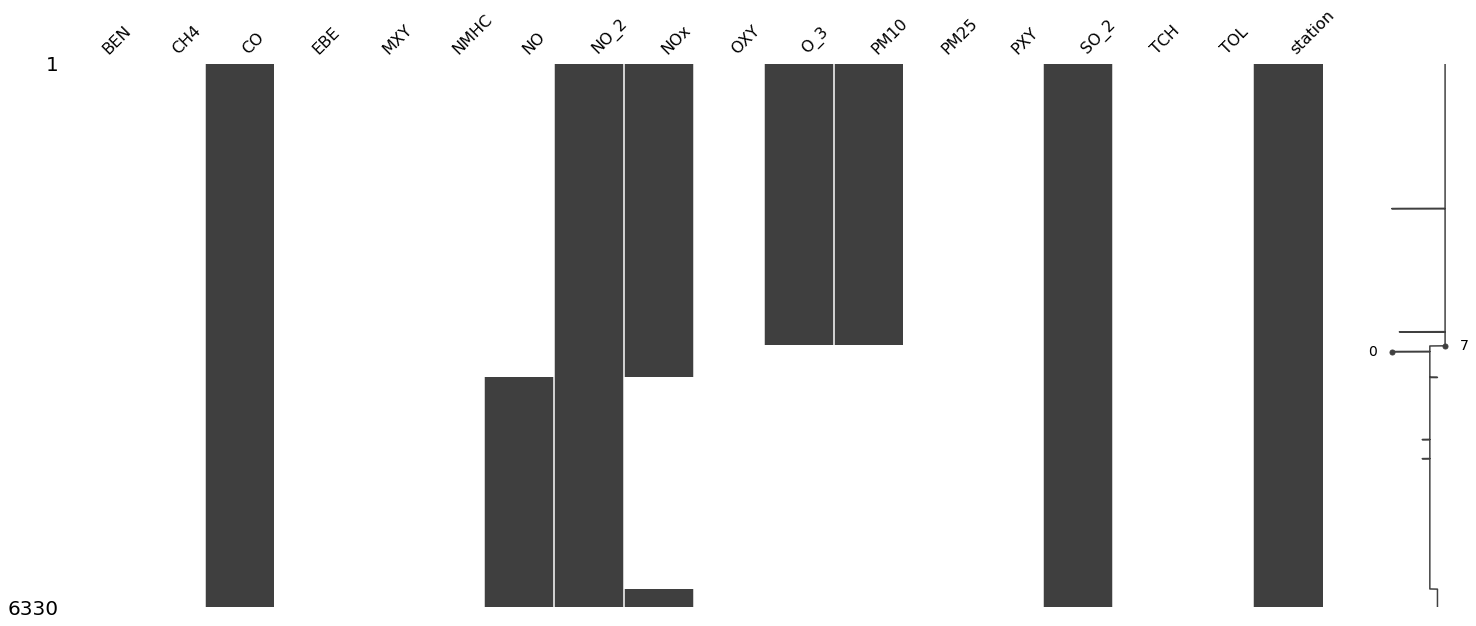

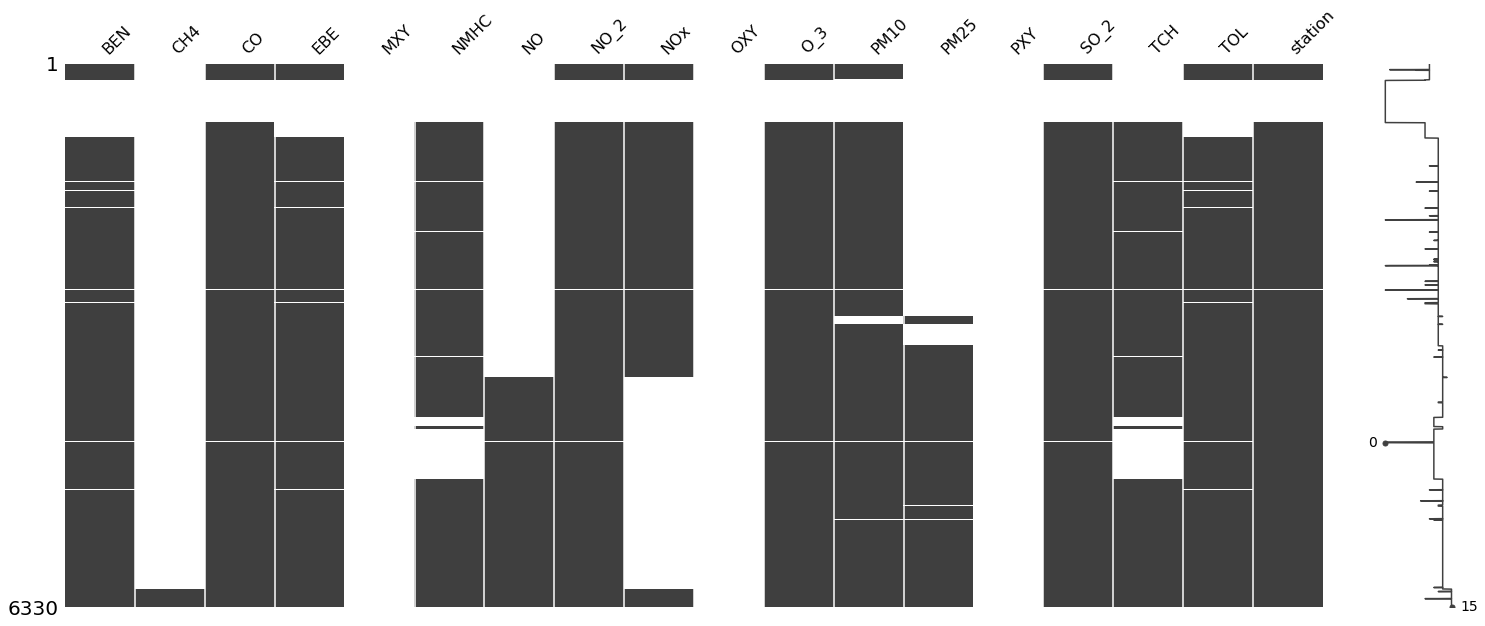

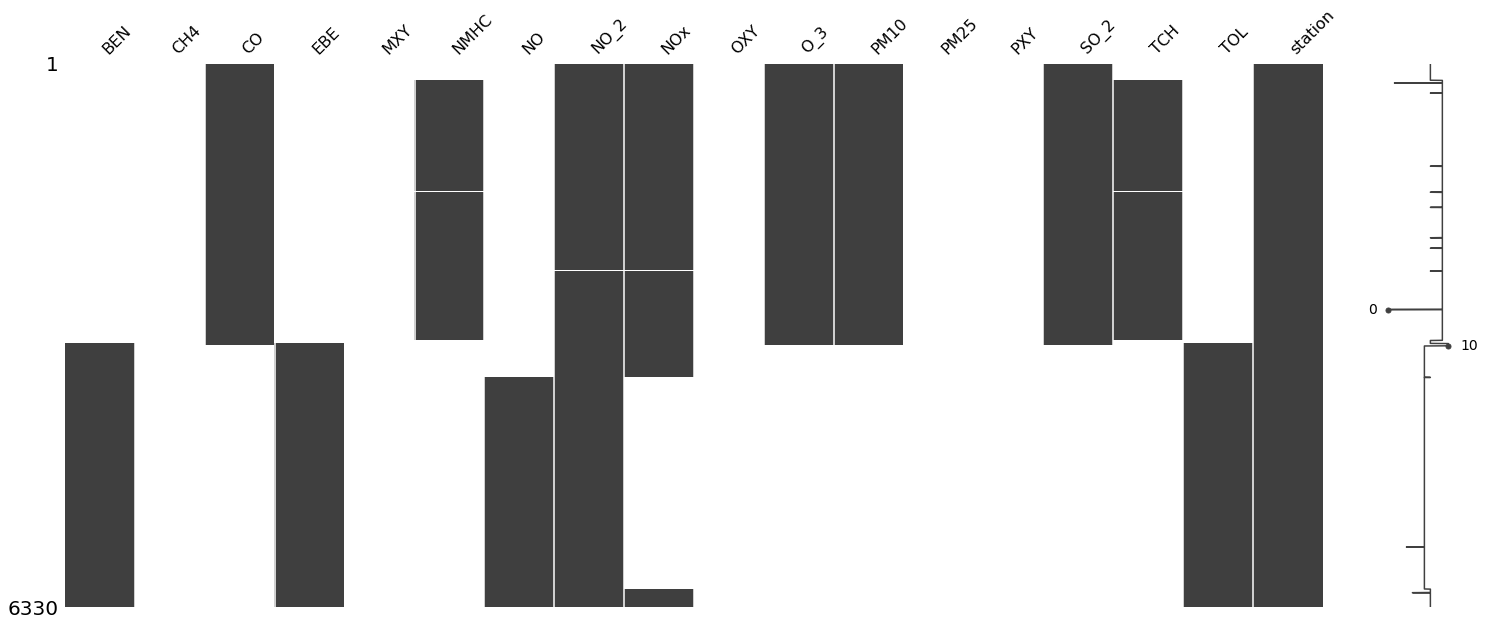

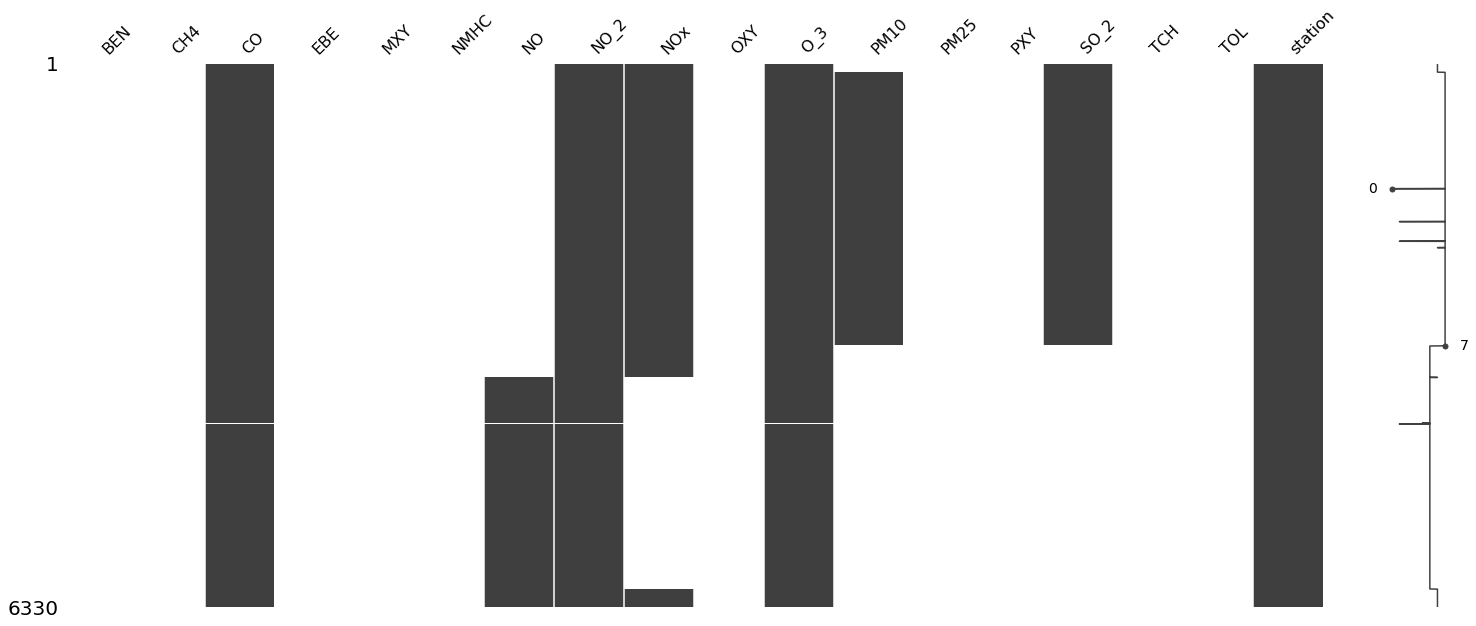

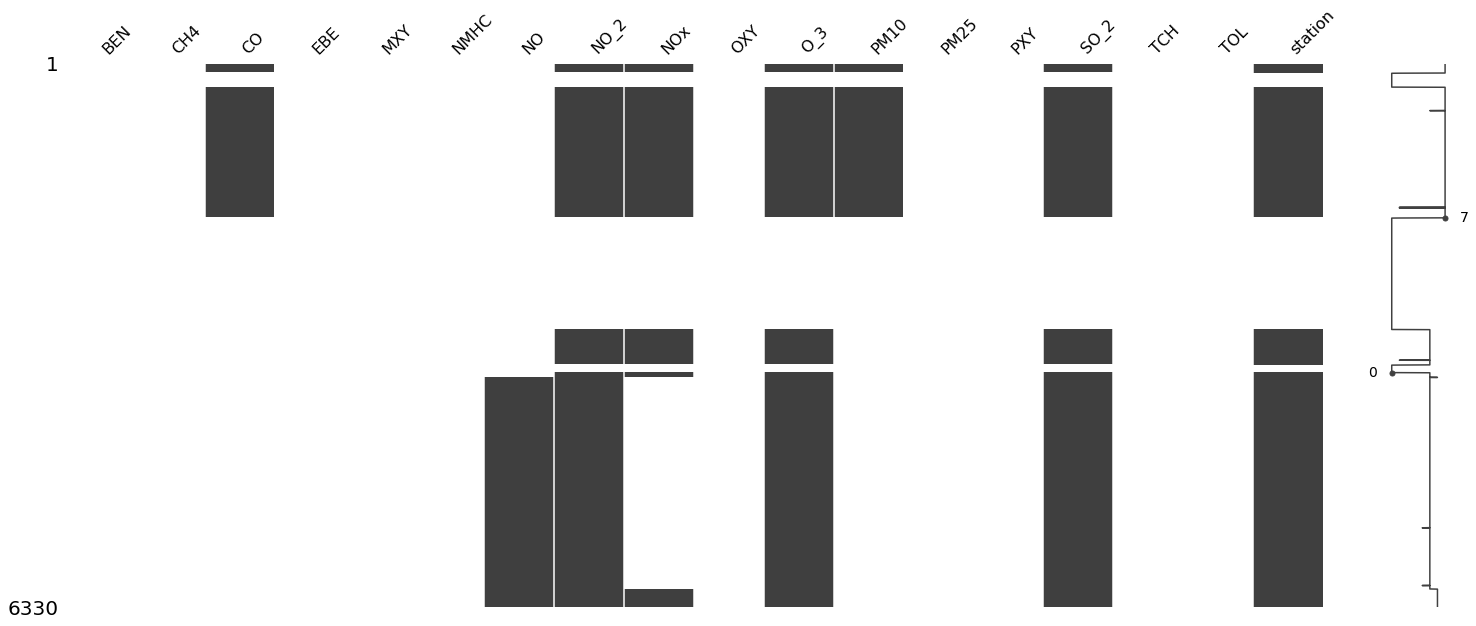

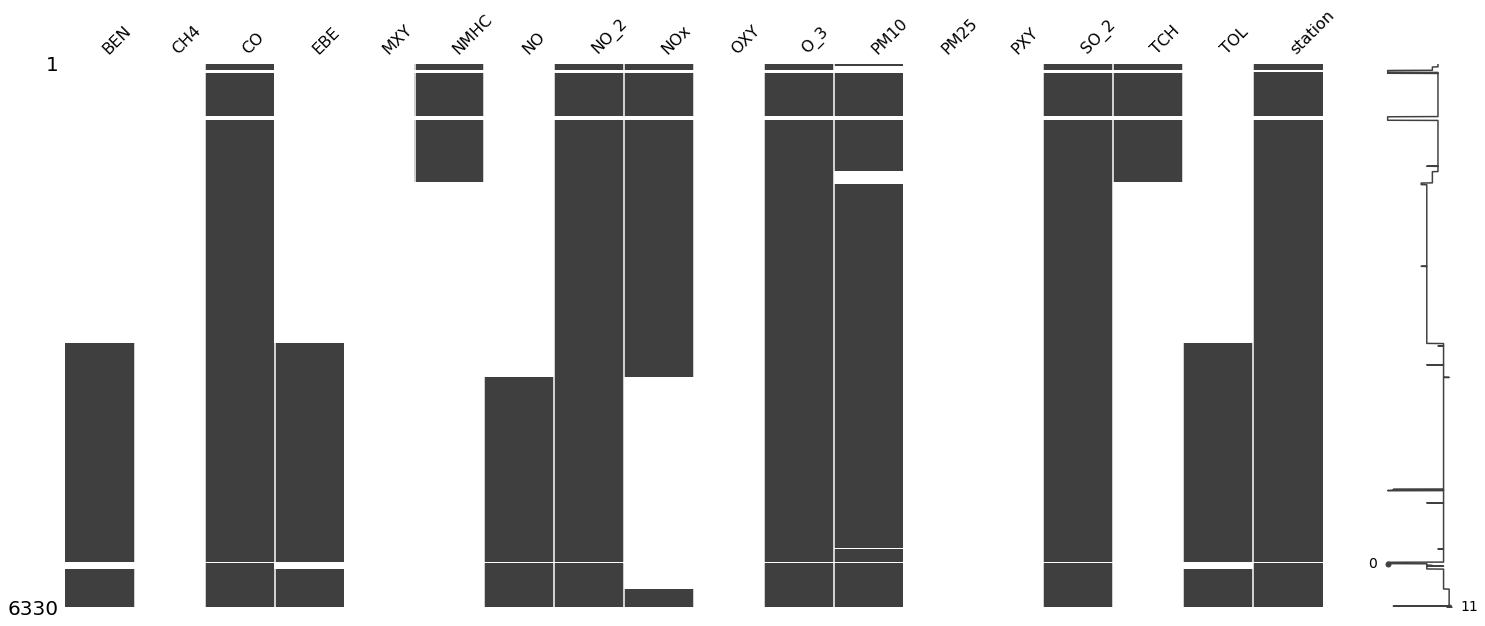

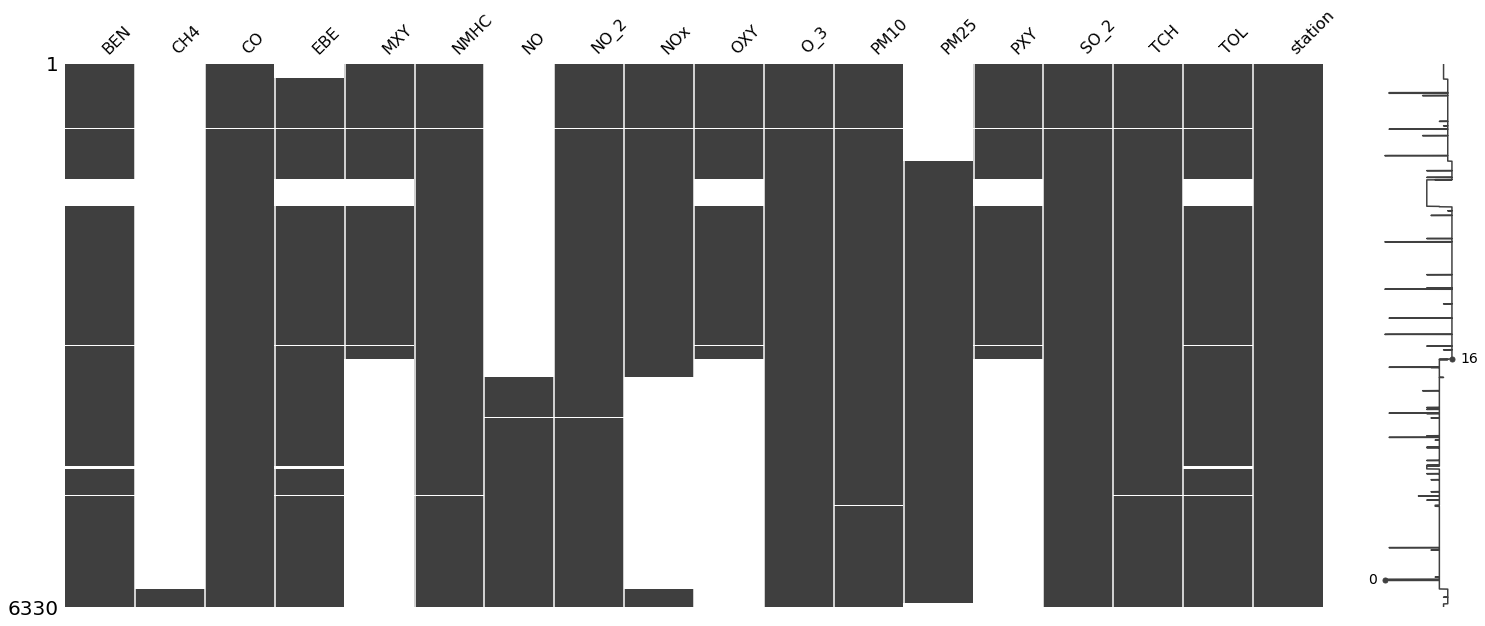

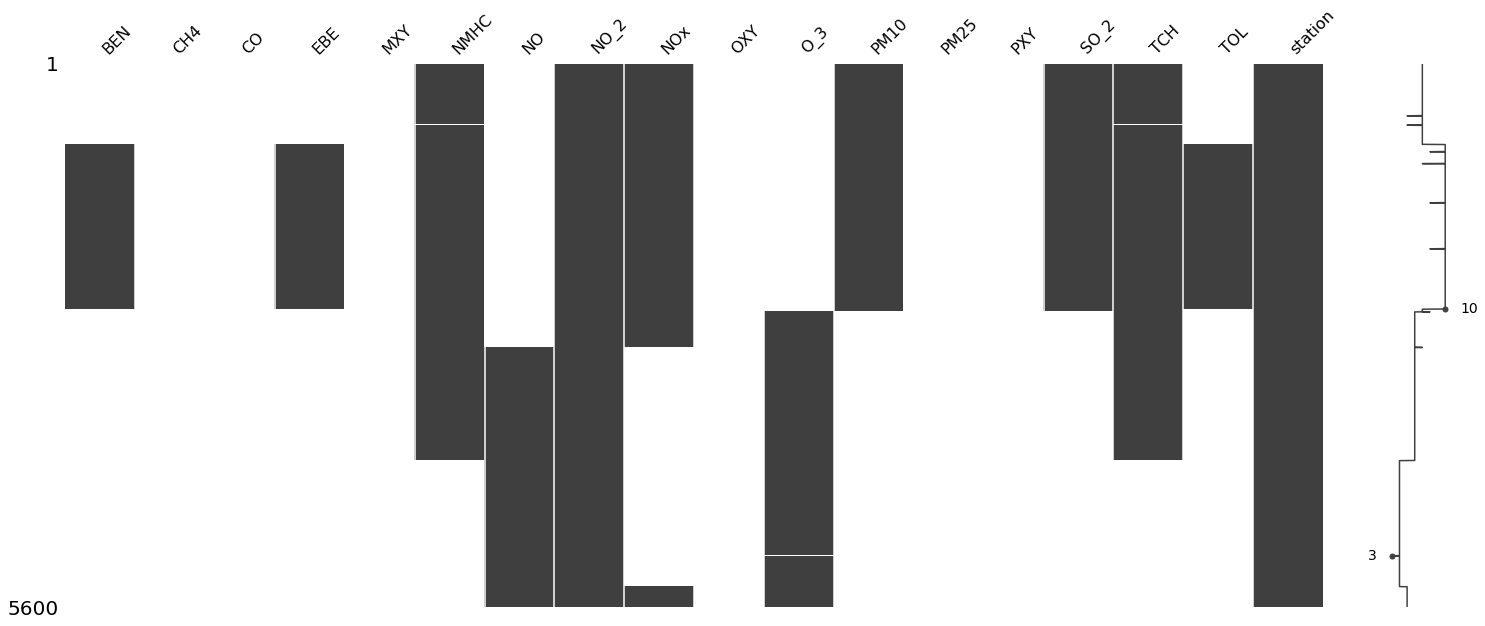

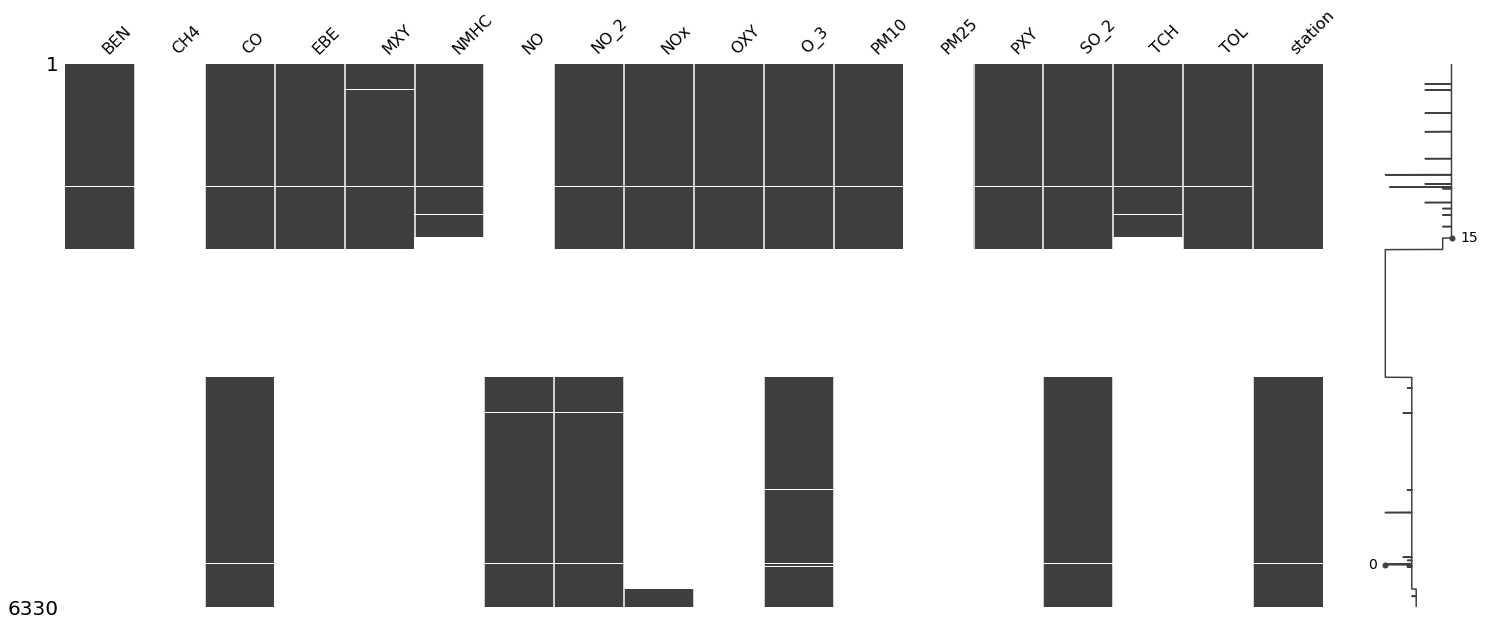

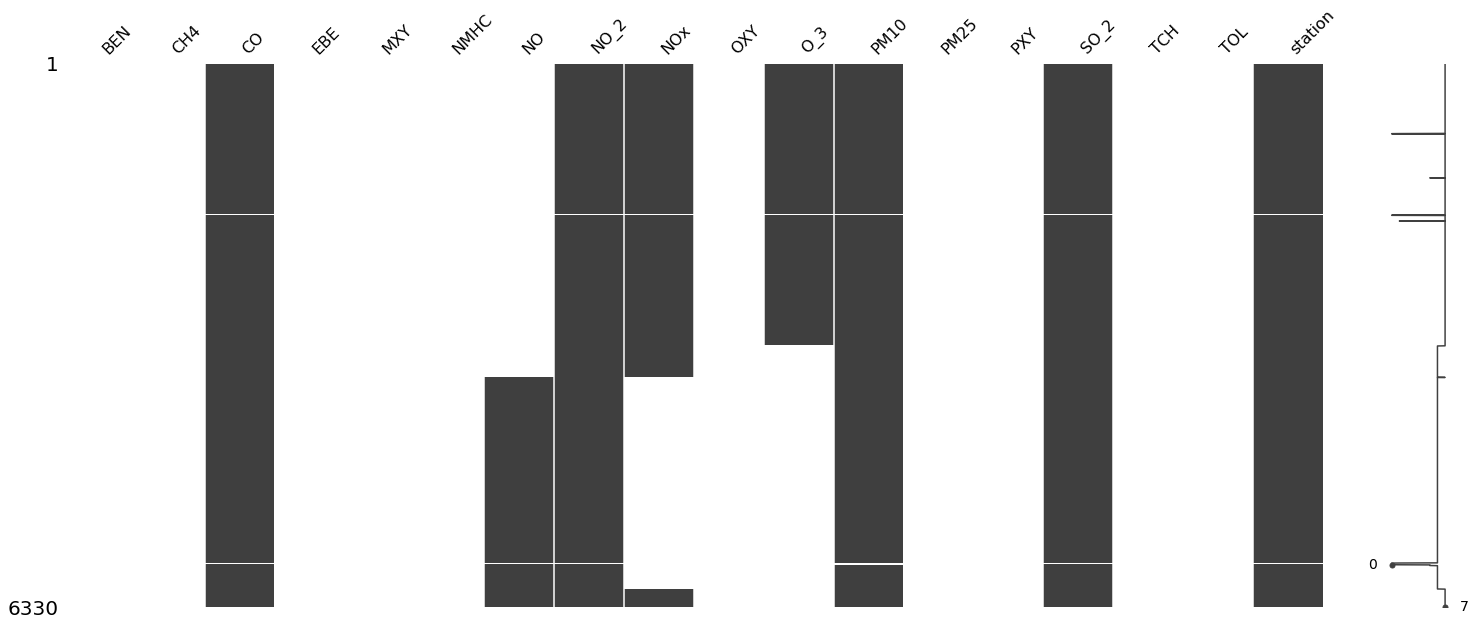

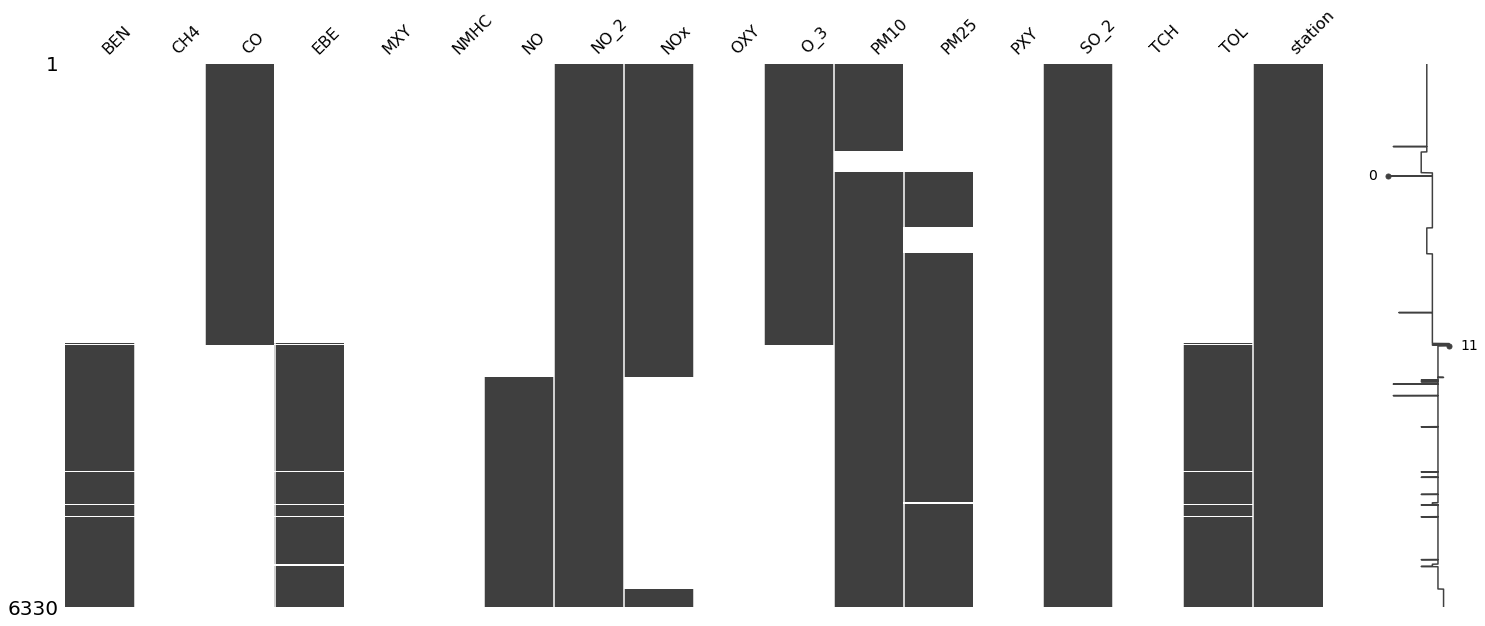

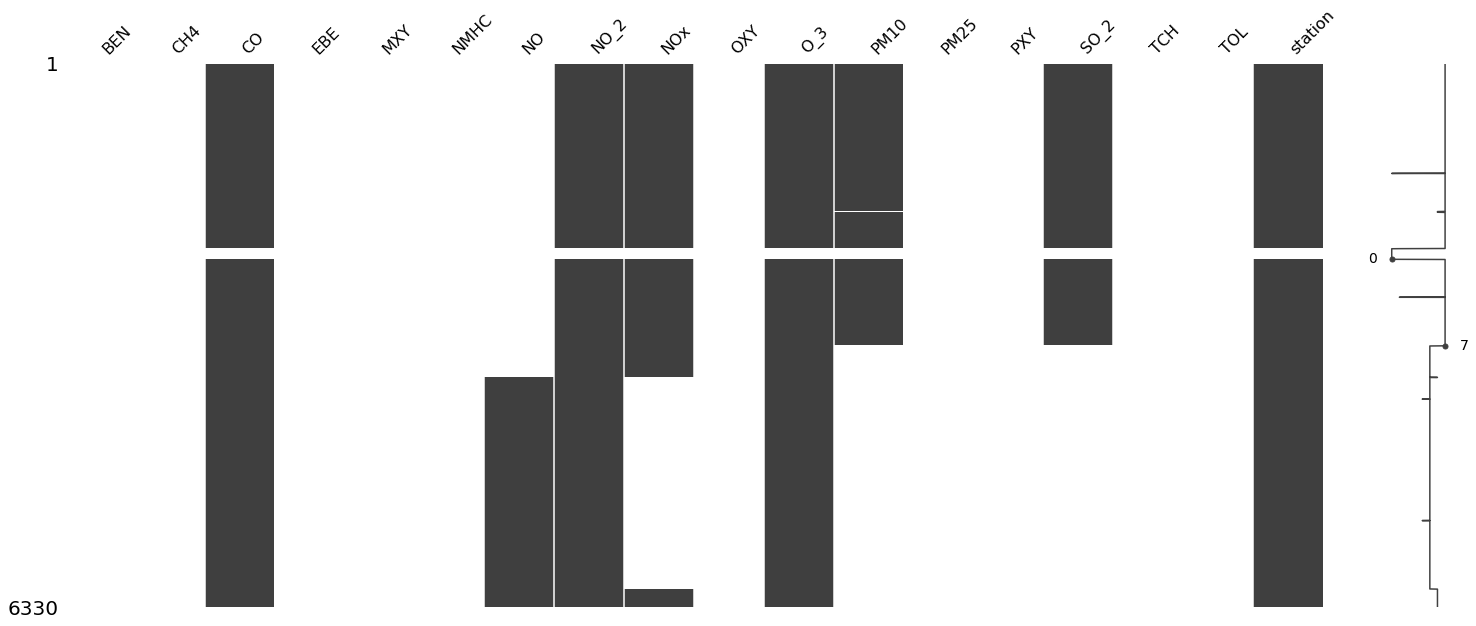

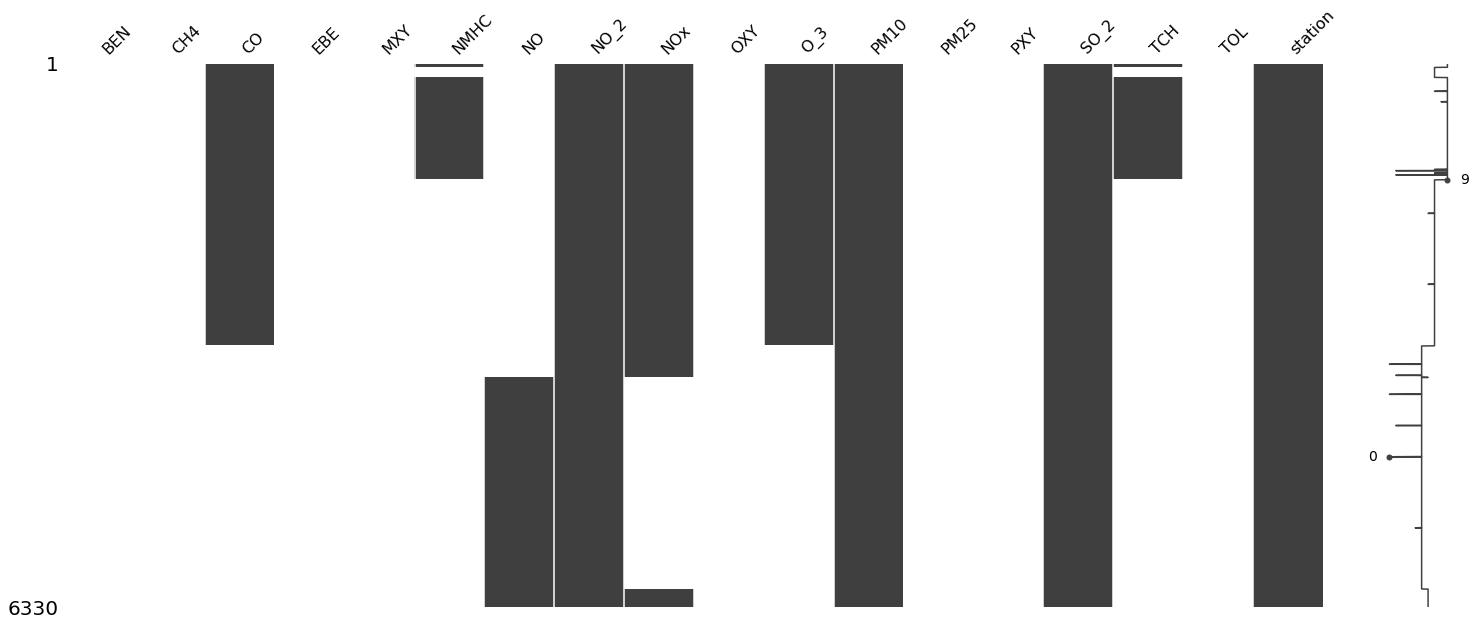

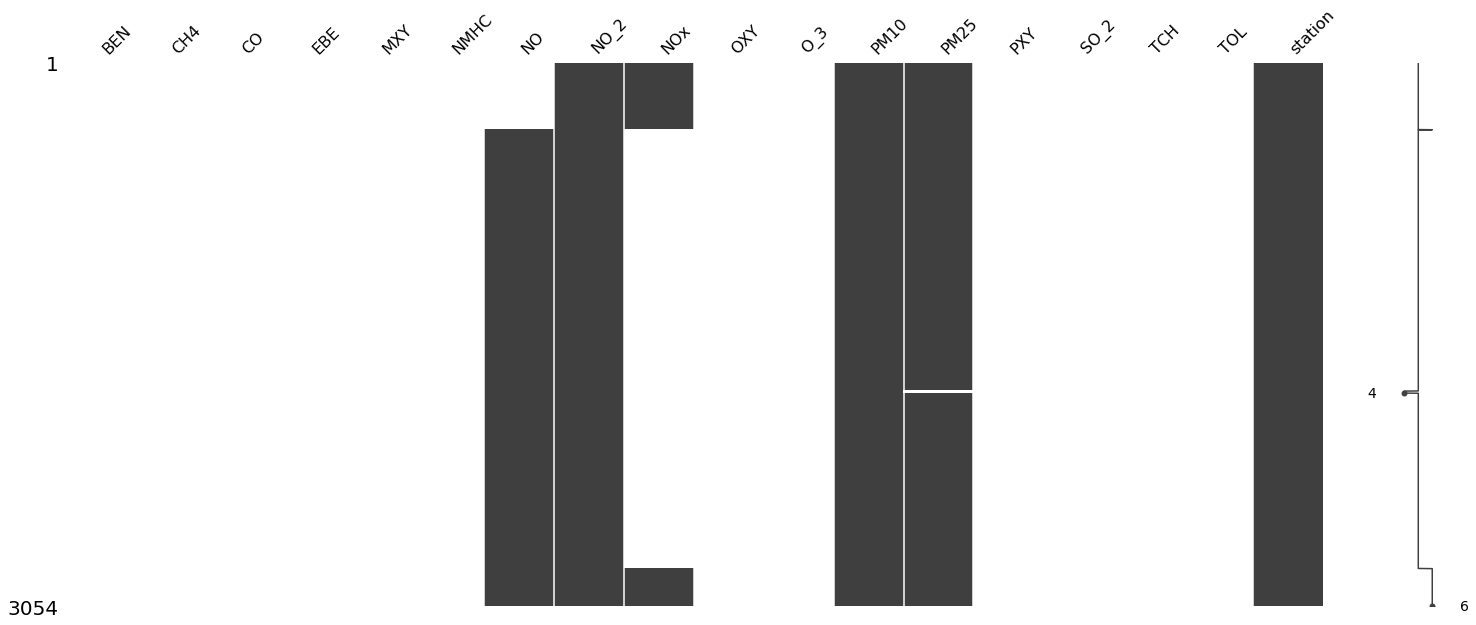

In [95]:
for stnindx in range(numStnsToAnalyze):
    msno.matrix(stndatamap[newstns[stnindx]])

While this helps to visually get a sense of the gaps in the data, it would help us if we can get the starting point for each of the gas series', which could be in different years, not necessarily in the first year. We will pick out data for the first 10 years for the first 14 stations as stated above.

## Separating training and test data
We need to set aside some of the data for testing. So we will use data until 2012 for training, and use 2013 to test our model and finally use 2014 data as unseen data that we will try on our model to see how it performs.

## Build our training data
This data will comprise the target series, any categories, such as stations and the gases that the observations have recorded and finally some dynamic features that the we would like to account for.
To the _target_ series we will add a few categories i.e. the station, as the specifics of a station would affect the predictions and the gas. So two _categories_. We would also require _dynamic features_ to be added. We want to track dynamic features that indicate the transition of seasons from warm weather to cold and then back to warm weather, if the geographical region experiences seasonal precipitation, that too can affect the levels of the gases observed and all of this, for now seems to be captured by a dynamic feature such as the distance from the last and approaching solstice. So, for each datapoint we will track the last solstice (it would either be summer or winter) and the apporaching solstice. The summer solstice occurs on the 21st of June and the winter solstice occurs on the 21st of December. To know more about solstices please refer [this](https://en.wikipedia.org/wiki/Solstice) wikipedia link. Note that solstices go the other way around in the southern hemisphere. There are ofcourse, equinoxes to be considered and many other complexities that we will not explore in this particular usecase. You could explore that using additional dynamic features and categories, as applicable.

To better understand categories and dynamic features, refer to the DeepAR documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html) and this blog [here](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-deepar-now-supports-missing-values-categorical-and-time-series-features-and-generalized-frequencies/). 

In [96]:
sollist,sollistv2 = [],[]

## We don't want to deal with the index, so copying it to a new column so we will work with it.
for stn in range(numStnsToAnalyze):
    stndatamap[newstns[stn]]['observationDate'] = stndatamap[newstns[stn]].index

## We will be using PyEphem to compute all the solstices, so lets get the Solstices first
for yr in range(2000,2019):
    nsol1 = ephem.next_solstice(str(yr))
    nsol2 = ephem.next_solstice(nsol1)
    strdt = nsol1.datetime().strftime("%Y-%m-%d")
    sollist.append(strdt)
    sollistv2.append(datetime.datetime.strptime(sollist[-1],"%Y-%m-%d").date())
    strdt = nsol2.datetime().strftime("%Y-%m-%d")
    sollist.append(strdt)
    sollistv2.append(datetime.datetime.strptime(sollist[-1],"%Y-%m-%d").date())

## We calculate the distances from solstices and return the values, the input is observation date 
## i.e. same name as the column in our dataframes(inputs). We then populate the other columns.
def getDistFromSolstices(obdt):
    indx = bisect.bisect(sollistv2,obdt.date())
    return (obdt.date()-sollistv2[indx-1]).days,(sollistv2[indx]-obdt.date()).days


def populateDistance(datamap,newstns):
    for stn in range(numStnsToAnalyze):
        dsfromlast,dsfromnext = [],[]
        for row in datamap[newstns[stn]].itertuples():
            dfromlast,dfromnext = getDistFromSolstices(row[19])
            dsfromlast.append(dfromlast)
            dsfromnext.append(dfromnext)
        datamap[newstns[stn]] = datamap[newstns[stn]].assign(distanceFromLastSolstice=pd.Series(dsfromlast,index=datamap[newstns[stn]].index))
        datamap[newstns[stn]] = datamap[newstns[stn]].assign(distanceFromNextSolstice=pd.Series(dsfromnext,index=datamap[newstns[stn]].index))
    return datamap

stndatamap = populateDistance(stndatamap,newstns)

### Building the input files
We now have all of our data where we want it. Let us now start with building the files for the training and test phases.

In [97]:
## Build the data structures required to create our training and test data. Input for this function is the 
## station id i.e. newstns[<subscript>]
def getDataBlocks(datamap,station,gaslist):
    blocklist,gasblocks = [],[] ## We rely on the position of the gases in our dataframe, same as the order in the gaslist variable
    for gas in gaslist:
        gasblocks = []
        if len(datamap[station][gas]) != 0:
            ts = pd.Series(datamap[station][gas],index=datamap[station].index)
            sts = ts.to_sparse(fill_value=np.nan,kind='block')
            bl_locs = zip(sts.sp_index.blocs, sts.sp_index.blengths)
            for start,length in bl_locs:
                gasblocks.append({'start': start, 'length': length})
        else:
            gasblocks.append({'start': 0, 'length': 0})
        blocklist.append(gasblocks) ## Each Gas block contains the blocks for a specific gas for that station
    return blocklist

## This function gets the blocks that will be used for testing, this is the starting 365 days worth of data,
## it identifies the index of the blocks that will be used for testing from the gasblocks list and returns the 
## offset into the block that is to be partly used, this is also data that will be required by the code that
## generates the training dataset.
def getTrainBlocks(blocklist,yrs):
    indx,sumblks,trainblocks,dpts = 0,0,[],365*yrs ## testblocks has a blockindex & an offset term
    for gas in blocklist:
        gasdata = [blk['length'] for blk in gas]
        ndx = np.array(gasdata)
        if len(gasdata) == 0 or np.sum(ndx) <= dpts:
            trainblocks.append({'blockindex': 0, 'offset': 0}) # Not enough data to test
            continue
        sm,blkindx,diff = 0,0,0
        for i,cnt in zip(gasdata,range(len(gasdata))):
            sm += i
            if sm >= dpts:
                blkindx = cnt
                break
        if sm > dpts: ## we will have to split a block
            ##<note enough data for training, no need to test either>
            diff = sm - dpts
            trainblocks.append({'blockindex': blkindx, 'offset': diff})
        else: ## we have exactly what we need, so we start from a block boundary
            ##<we seem to be in a good position to go ahead and train in the rest of the data, we will have to split the last block>
            trainblocks.append({'blockindex': blkindx+1, 'offset': 0}) 
    return trainblocks

In [68]:
s = pd.Series(stndatamap[newstns[0]]['NO'],index=stndatamap[newstns[0]].index)
s.first_valid_index().date().strftime("%Y-%m-%d")

'2011-01-01'

In [98]:
yrs = 5 ## years of data to use for training

## We use a helper to build the input files for the training and test phases
def writeData(fname,datamap,newstns,stncats,gascats,gaslist): ## This will call getDataBlocks and getTestBlocks
    trdata = []
    f = open(fname,'w')
    for stn in range(numStnsToAnalyze):
        bl = getDataBlocks(datamap,newstns[stn],gaslist)
        tb = getTrainBlocks(bl,yrs)
        for t,gas in zip(tb,gaslist):
            starttime=0
            if len(bl[gascats[gas]]) == 0:
                continue
            if t['blockindex'] == 0 and t['offset'] == 0:
                continue
            ts = pd.Series(datamap[newstns[stn]][gas],index=datamap[newstns[stn]].index)
            location = bl[gascats[gas]][t['blockindex']]['start']+t['offset'] ## This is where our training data ends
            starttime = ts.first_valid_index().date().strftime("%Y-%m-%d") + ' 00:00:00' 
            ts = ts.replace(np.nan,'NaN',regex=True)
            targ = ts.iloc[:location+1].tolist()
            gasc = gascats[gas]
            stnc = stncats[newstns[stn]]
            tsdfl = pd.Series(datamap[newstns[stn]]['distanceFromLastSolstice'],index=datamap[newstns[stn]].index)
            distfromlasts = tsdfl.iloc[:location+1].tolist()
            tsdfn = pd.Series(datamap[newstns[stn]]['distanceFromNextSolstice'],index=datamap[newstns[stn]].index)
            distfromnexts = tsdfn.iloc[:location+1].tolist()
            trdata.append({
                    "start": starttime,
                    "target": targ[:],
                    "cat": [gasc,stnc],
                    "dynamic_feat": [distfromlasts,distfromnexts]
            })
            print("Writing data for gas {} and station ID {}".format(gas,newstns[stn]))
            #line = "\"start\": \"{}\",\"target\": {}\",\"cat\": {}\",\"dynamic_feat\": [{},{}]".format(starttime,targ,[gasc,stnc],distfromlasts,distfromnexts)
            #f.write("{"+line+"}\n")
    for datapoint in trdata:
        f.write(json.dumps(datapoint).encode("utf-8"))
        f.write("\n".encode('utf-8'))
    f.close()
    print("####***Datapoints generated***####")

writeData('traindata.json',stndatamap,newstns,stncats,gascats,gaslist)

Writing data for gas BEN and station ID 28079004
Writing data for gas CH4 and station ID 28079004
Writing data for gas CO and station ID 28079004
Writing data for gas EBE and station ID 28079004
Writing data for gas MXY and station ID 28079004
Writing data for gas NMHC and station ID 28079004
Writing data for gas NO and station ID 28079004
Writing data for gas NO_2 and station ID 28079004
Writing data for gas NOx and station ID 28079004
Writing data for gas OXY and station ID 28079004
Writing data for gas O_3 and station ID 28079004
Writing data for gas PM10 and station ID 28079004
Writing data for gas PM25 and station ID 28079004
Writing data for gas PXY and station ID 28079004
Writing data for gas SO_2 and station ID 28079004
Writing data for gas TCH and station ID 28079004
Writing data for gas TOL and station ID 28079004
Writing data for gas BEN and station ID 28079008
Writing data for gas CH4 and station ID 28079008
Writing data for gas CO and station ID 28079008
Writing data for g

Writing data for gas PM10 and station ID 28079039
Writing data for gas PM25 and station ID 28079039
Writing data for gas PXY and station ID 28079039
Writing data for gas SO_2 and station ID 28079039
Writing data for gas TCH and station ID 28079039
Writing data for gas TOL and station ID 28079039
Writing data for gas BEN and station ID 28079040
Writing data for gas CH4 and station ID 28079040
Writing data for gas CO and station ID 28079040
Writing data for gas EBE and station ID 28079040
Writing data for gas MXY and station ID 28079040
Writing data for gas NMHC and station ID 28079040
Writing data for gas NO and station ID 28079040
Writing data for gas NO_2 and station ID 28079040
Writing data for gas NOx and station ID 28079040
Writing data for gas OXY and station ID 28079040
Writing data for gas O_3 and station ID 28079040
Writing data for gas PM10 and station ID 28079040
Writing data for gas PM25 and station ID 28079040
Writing data for gas PXY and station ID 28079040
Writing data fo

## Now let us upload the data to S3
We will use Amazon SageMaker's own function to do that. You can take a look at it __[here](http://sagemaker.readthedocs.io/en/latest/session.html)__.

In [99]:
training_key = 'traindata.json'
train_prefix   = '{}/{}'.format(prefix, 'train')

## Lets create the sagemaker session and upload the data from where Amazon SageMaker will pick it 
## up to put in the container
sg_sess = Session()
training_path  = sg_sess.upload_data(training_key, bucket=bucket, key_prefix=train_prefix)

## Lets set up the training job

We first set up the containers we intend to use and then create an estimator

In [100]:
from sagemaker.amazon.amazon_estimator import get_image_uri

img = get_image_uri(boto3.Session().region_name,'forecasting-deepar')
prediction_length = 15 # days ahead
context_length = 180 # days previous

## A Simple way to train
You could just create an estimator as shown below. This is called the Python high level SDK. This makes it very easy to train. You can refer to [this URL](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-prog-model.html) for more details on the high level Python SDK for Amazon SageMaker.

```python
estimator = estimator.Estimator(
    sagemaker_session=sg_sess,
    image_name=img,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='Madrid-Air-Quality',
    output_path='s3://{}/{}'.format(bucket,output_prefix)
)
prediction_length = 15 # days ahead
context_length = 180 # days previous
hyperparameters = {
    "time_freq": 'D', # daily series
    "context_length": context_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "60", #default
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "100",
    "mini_batch_size": "512",
    "learning_rate": "0.01",
    "dropout_rate": "0.05"
}
estimator.set_hyperparameters(**hyperparameters)

data_channels = {"train": training_path}
estimator.fit(inputs=data_channels) ### This will launch the training job

### To get the model we have trained
h_level_api_model = estimator.latest_training_job.name

### You can eventually deploy, like so,

my_predictor = myalgo.deploy(initial_instance_count=2,instance_type='ml.m4.xlarge')
```

## Hyperparameters for DeepAR

__time_freq__ : The granularity of the time series in the dataset. Required. Use time_freq to select appropriate date features and lags. The model supports the following basic frequencies. It also supports multiples of these basic frequencies. For example, 5min specifies a frequency of 5 minutes.
 - M for monthly
 - W for weekly
 - D for daily
 - H for hourly
 - min for every minute

__prediction_length__ : The number of time-steps that the model is trained to predict, also called the forecast horizon. The trained model always generates forecasts with this length. It can't generate longer forecasts. The prediction_length is fixed when a model is trained and it cannot be changed later. 

__context_length__ : The number of time-points that the model gets to see before making the prediction. The value for this parameter should be about the same as the prediction_length. The model also receives lagged inputs from the target, so context_length can be much smaller than typical seasonalities. For example, a daily time series can have yearly seasonality. The model automatically includes a lag of one year, so the context length can be shorter than a year. The lag values that the model picks depend on the frequency of the time series. For example, lag values for daily frequency are previous week, 2 weeks, 3 weeks, 4 weeks, and year.

__likelihood__ : The model generates a probabilistic forecast, and can provide quantiles of the distribution and return samples. Depending on your data, select an appropriate likelihood (noise model) that is used for uncertainty estimates. The following likelihoods can be selected:
**gaussian** : Use for real-valued data
**beta** : Use for real-valued targets between 0 and 1 incl.
**negative-binomial** : Use for count data (non-negative integers).
**student-T** : An alternative for real-valued data that works well for bursty data.
**deterministic-L1** : A loss function that does not estimate uncertainty and only learns a point forecast.

__epochs__ : The maximum number of passes over the training data. The optimal value depends on your data size and learning rate. See also early_stopping_patience. Typical values range from 10 to 1000.

There are more...if you want to know more check __[here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html)__.

## There are some recommended best practices that would be good to consider when using DeepAR. 
You can find more details __[here](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html)__.

## Alternatively, you could use the low-level SDK

You can use the low-level SDK for Python which provides the create_traning_job method which maps to the _CreateTrainingJob_ Amazon SageMaker API. You will also be required to define the training parameters that give you more finegrained control over the training job.
You can also use a _Waiter_ to wait until the training job is over.

In [101]:
from time import gmtime, strftime

job_name = 'MyDeepARTraining-RNS-' + strftime("%Y-%m-%d-%H-%M-%S",gmtime())
print(job_name)
                                
## We have already setup the containers above
                                
## We choose a different output location to keep these separate from our old artifacts
output_location = 's3://{}/{}/output'.format(bucket,prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": img,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 4,
        "InstanceType": "ml.c4.2xlarge",
        "VolumeSizeInGB": 10
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "time_freq": 'D', # daily series
        "context_length": str(context_length),
        "prediction_length": str(prediction_length), # number of data points to predict
        "num_dynamic_feat": "auto",
        "num_cells": "60", 
        "num_layers": "3",
        "likelihood": "gaussian", #real world data
        "epochs": "400",
        "mini_batch_size": "128",
        "learning_rate": "0.01",
        "dropout_rate": "0.1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 120 # Give it two hours at best, could increase this for production scale
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": training_path,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}

sgmaker = boto3.client('sagemaker')
sgmaker.create_training_job(**create_training_params)

## Lets check the status of the job to see if its complete, and lets wait until its done
status = sgmaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
try:
    sgmaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sgmaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sgmaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

MyDeepARTraining-RNS-2018-09-05-10-44-06
training artifacts will be uploaded to: s3://rnszsdemo/sagemaker/data/Madrid_Air_Quality/output
InProgress
Training job ended with status: Failed
Training failed with the following error: ClientError: Error when parsing json (source: /opt/ml/input/data/train/traindata.json, row: 1)


Exception: Training job failed

## Deploying the model to Amazon SageMaker hosting services

There are 3 steps to host a model in Amazon SageMaker,
 - Create a model in Amazon SageMaker
 - Create an endpoint configuration
 - Create an endpoint

### Create the model

In [ ]:
modelname = job_name
print(modelname)

## Lets find out where our model artifacts have been stored, first for the model artifacts from the low level SDK
info = sgmaker.describe_training_job(TrainingJobName=job_name)
modeldata = info['ModelArtifacts']['S3ModelArtifacts']
primary_ctnr = {
    'Image': img,
    'ModelDataUrl': modeldata
}

## Create the actual model
cmr = sgmaker.create_model(
    ModelName = job_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_ctnr)

## You should now be able to get the model ARN
print(cmr['ModelArn'])

### Endpoint configuration creation

In [ ]:
endpoint_config_name = 'MyDeepAREP-RNS-'+strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sgmaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [{
            "InitialInstanceCount": 1,
            "InstanceType": "ml.m4.xlarge",
            "ModelName": modelname, 
            "VariantName": 'All Traffic'
        }]
)
print("Endpoint Config Arn: "+create_endpoint_config_response['EndpointConfigArn'])

### If you had more than one model and wanted to distribute traffic among them...
You could set it up like below, for details of such a configuration, refer to [this URL](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateEndpointConfig.html).

```python
create_endpoint_config_response = sgmaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants = [{
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 2,
            "InstanceType": "ml.m4.xlarge",
            "ModelName": modelname1, 
            "VariantName": modelname1
        },
        {
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 2,
            "InstanceType": "ml.m4.xlarge",
            "ModelName": modelname2, 
            "VariantName": modelname2            
        }
    ]
)
```

### create the endpoint

In [ ]:
endpoint_name = 'MyDeepAREndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sgmaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sgmaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sgmaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sgmaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sgmaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')


# Application autoscaling can be configured using __[this](https://docs.aws.amazon.com/sagemaker/latest/dg/endpoint-auto-scaling-add-policy.html)__.

In [ ]:
ReqSet = []
ValidationChkSet = [] 

## Lets create a helper function for the creation of the request
def createRequest(fname,dataset):
    f = open(fname,'w')
    line1 = "\"start\":\"{}\",\"target\":{}".format(str(startTimes[8]),dataset[1])
    # We want only 10 samples for this exercise
    line2 = "\"instances\": [{"+line1+"}],\"configuration\": {\"num_samples\": 50,\"output_types\": [\"mean\",\"quantiles\",\"samples\"],\"quantiles\": [\"0.1\",\"0.9\"]}"
    f.write('{'+line2+'}\n')
    f.close()

## Don't want to keep these undefined
ReqSet.append([0])
ValidationChkSet.append([0])    

## Lets get what we need for our request first, we will use month 9, remember we have trained the model on the first 8 months.
ReqSet.append(eachstn[0]['O_3'][:'2001-{}-25'.format(9)].tolist()) # You may __not__ want to **hardcode** this

## The below will be used to check how we are predicting
ValidationChkSet.append(eachstn[0]['O_3']['2001-{}-25'.format(9):'2001-{}-28'.format(9)].tolist())


In [ ]:
createRequest('RequestData.json',ReqSet)
createRequest('ValidationData.json',ValidationChkSet)

Lets see how the request files have turned out, note we didn't really need validation data to be put into the request format, but its easier to look at smaller data than the larger request data that has more data points

In [ ]:
!cat ValidationData.json

### Lets do the prediction
We obtained the endpoint name from above endpoint creation process

In [ ]:
runtime = boto3.Session().client('sagemaker-runtime')
## Create bytes for the payload
with open("ValidationData.json","rb") as f:
    reqcontents = f.read()
payload = reqcontents

## This comes from the previous call that gives us our endpoint
response = runtime.invoke_endpoint(EndpointName=endpoint_name,ContentType='application/json',Body=payload)

### So now we have the predictions! Lets look at what we got.

In [ ]:
print(response)

So we can see from the above many of the details, we are specifically interested in the `InvokedProductionVariant`. What we get is a `botocore.response.StreamingBody`, thats where your predictions are. You need to be able to read the `StreamingBody` to get to the predictions.
The Stream that we get from the `response`(above) can be used only once as it doesn't survive across calls. We get the whole thing in one read call, not really a best practice. You may want to read fewer bytes at a time by passing the `read()` a bytes parameter.
Storing the stream in `datamy` helps me access the data later, as and when I want, now we can proceed with choosing to display one of the forecasts.
Getting string data. If you want the `StreamingBody`, you would have to call invoke_endpoint again!!! Of course! :-)
since we have already read the stream.

In [ ]:
import json

my_json = (response['Body']).read()
datamy = json.loads(my_json)

## Lets look at the predictions

In [ ]:
import random

q1 = 0.1
q2 = 0.9

y_data = datamy['predictions'][0]
y_mean = y_data['mean']
y_q1 = y_data['quantiles'][str(q1)]
y_q2 = y_data['quantiles'][str(q2)]

## Since we now have everything, lets plot this to compare the predictions with real values

In [ ]:
x = range(0,prediction_length) 
plt.gcf().clear()
fig = plt.figure(figsize=(20,10))
meanlbl, = plt.plot(x,y_mean,'k--',label='mean')
q1lbl, = plt.plot(x,y_q1,'g',label=q1)
q2lbl, = plt.plot(x,y_q2,'b',label=q2)
truth_data = eachstn[0]['O_3']['2001-{}-26'.format(9):'2001-{}-28'.format(9)].tolist()
gtlbl, = plt.plot(x,truth_data,'m',label='truth')
plt.legend(handles=[meanlbl,q1lbl,q2lbl,gtlbl])
plt.show()

We obviously need more training or need to tune our hyperparameters better. That bring us to 
### Automated Model Tuning

Refer to this __[page](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html)__ for a detailed explanation of how to tune DeepAR models, and this __[page](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)__ for a detailed explanation of Automatic Model Tuning in Amazon SageMaker.
Some other tools that you can use for automatic model tuning in Python : __[Spearmint](https://github.com/JasperSnoek/spearmint)__, __[MOE](https://github.com/Yelp/MOE)__, __[HyperOpt](https://github.com/hyperopt/hyperopt)__ and __[SMAC](https://github.com/automl/SMAC3)__.
We will use AMT to tune our model like so,
 - We create an estimator, just like we did when we wanted to create the model (see above)
 - Then we setup the hyperparameter ranges that AMT will will explore to get the optimal model
 - Setup the `tuner`
 - Then run tuner.fit()
 
 To analyze the results of the hyperparameter optimzation task, use __[this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb)__.

In [ ]:
from sagemaker import estimator

training_key = 'trainingData.json'
testing_key = 'testData.json'
train_prefix   = '{}/{}'.format(prefix, 'train-HPO')
test_prefix    = '{}/{}'.format(prefix, 'test-HPO')
output_prefix = '{}/{}'.format(prefix, 'output-HPO')

## Lets create the sagemaker session
sg_sessV2 = Session()
training_path  = sg_sess.upload_data(training_key, bucket=bucket, key_prefix=train_prefix)
testing_path = sg_sess.upload_data(testing_key, bucket=bucket, key_prefix=test_prefix)

estimatorHPO = estimator.Estimator(
    sagemaker_session=sg_sessV2,
    image_name=img,
    role=role,
    train_instance_count=2,
    train_instance_type='ml.c4.8xlarge',
    base_job_name='Madrid-Air-Quality-With-HPO',
    output_path='s3://{}/{}'.format(bucket,output_prefix)
)
prediction_length = 72 # Three days ahead?!
## Here we don't have the hyperparameters that we intend to tune
hyperparameters = {
    "time_freq": 'H', # hourly series
    "context_length": prediction_length,
    "prediction_length": prediction_length, # number of data points to predict
    "num_cells": "40", #default
    "num_layers": "2",
    "likelihood": "gaussian",
    "epochs": "50",
    "mini_batch_size": "128",
    "learning_rate": "0.01",
    "dropout_rate": "0.05"#,
#    "early_stopping_patience": "10" # stop if loss hasn't improved in 10 epochs
}

estimatorHPO.set_hyperparameters(**hyperparameters)

### Set up the hyperparameter ranges
The HPO algorithm used by Amazon SageMaker will explore the ranges specified. With continuous ranges, it can explore 
a lot more values than with integer ranges.

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.01, 0.2),'num_layers': IntegerParameter(2,5)}

### Metric definitions
If you are using a builtin algorithm, like we are here, you should __not__ provide the metric definition.
At other times, like if you are using your own say, tensorflow script __OR__ your own framework, you __will__ definitely have to provide metric definitions.

In [ ]:
objective_metric_name = 'train:final_loss'
objective_type = 'Minimize'

In [ ]:
tuner = HyperparameterTuner(estimatorHPO,objective_metric_name,hyperparameter_ranges,max_jobs=1,max_parallel_jobs=1,objective_type=objective_type)

The parameter `include_cls_metadata=False` to the `fit()` method is required as Amazon SageMaker HPO for DeepAR will not work without it. To get more detailed information on why this argument to `fit()` is required, check __[here](https://github.com/aws/sagemaker-python-sdk/blob/master/README.rst)__.
To check the status of your Hyperparameter tuning job, you can use this notebook (or the code in it): In your notebook instance click the `SageMaker Examples` tab, go to the section on `Hyperparameter Tuning`, `Use` the notebook `HPO_Analyze_TuningJob_Results.ipynb`. In this notebook, replace the name of the Hyperparameter tuning job with the one you get from the `fit()` method below.

In [ ]:
tuner.fit({'train': training_path, 'test': testing_path},include_cls_metadata=False)

### Remember to delete your endpoint.

In [ ]:
cl = boto3.client('sagemaker')
response = cl.delete_endpoint(EndpointName=endpoint_name)